## Import modules

In [1]:
import numpy as np
import numpy.random as random
import pandas as pd
import scanpy as sc
import anndata
import matplotlib.pyplot as plt

In [2]:
import session_info
session_info.show()

In [3]:
sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.settings.set_figure_params(dpi=120, facecolor='white', color_map = 'RdPu',)

## Read in data

* batch_key: donor + nuclei_or_cells + kit_10x

In [4]:
adata = sc.read_h5ad('/nfs/team205/heart/anndata_objects/Foetal/scVI/RNA_foetal_scVI.h5ad')
adata

AnnData object with n_obs × n_vars = 312100 × 3317
    obs: 'latent_RT_efficiency', 'latent_cell_probability', 'latent_scale', 'sangerID', 'combinedID', 'donor', 'donor_type', 'region', 'region_finest', 'age', 'gender', 'facility', 'cell_or_nuclei', 'modality', 'kit_10x', 'flushed', 'scrublet_score', 'scrublet_leiden', 'cluster_scrublet_score', 'doublet_pval', 'doublet_bh_pval', 'n_genes', 'n_counts', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'HB_score', 'batch_key', '_scvi_batch', '_scvi_labels'
    var: 'gene_name_scRNA-0', 'gene_name_multiome-1', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection'
    uns: '_scvi', 'hvg'
    obsm: 'X_scVI', '_scvi_extra_continuous', 'latent_gene_encoding'
    layers: 'counts'

In [5]:
genename_column='gene_name_multiome-1'

In [6]:
# add previous annotation
prev=sc.read_h5ad('/nfs/team205/heart/anndata_objects/Foetal/final_annotation/adataRaw27Oct.h5ad')

adata.obs['previous_coarse_grain'] = prev.obs['coarse_grain'].reindex(adata.obs_names)
adata.obs['previous_mid_grain'] = prev.obs['mid_grain'].reindex(adata.obs_names)
adata.obs['previous_fine_grain'] = prev.obs['fine_grain'].reindex(adata.obs_names)

In [7]:
pd.crosstab(adata.obs['donor'],adata.obs['age'])

age      8w2d  8w5d  9w1d  9w3d  9w6d  11w3d  GA-6w3d  GA-7w4d  GA-8w1d  \
donor                                                                     
BRC2251     0     0  9651     0     0      0        0        0        0   
BRC2252  7366     0     0     0     0      0        0        0        0   
BRC2256     0     0     0     0  8525      0        0        0        0   
BRC2260     0     0     0     0     0   8408        0        0        0   
BRC2262     0  4749     0     0     0      0        0        0        0   
BRC2263     0     0     0  5917     0      0        0        0        0   
C82         0     0     0     0     0      0        0        0        0   
C85         0     0     0     0     0      0        0        0        0   
C86         0     0     0     0     0      0        0        0        0   
C87         0     0     0     0     0      0        0        0        0   
C92         0     0     0     0     0      0        0    15436        0   
C94         0     0     0     0     0      0        0        0        0   
C97         0     0     0     0     0      0        0        0    17388   
C98         0     0     0     0     0      0        0        0        0   
C99         0     0     0     0     0      0        0        0        0   
C104        0     0     0     0     0      0     3425        0        0   
Hst33       0     0     0     0     0      0        0        0        0   
Hst41       0     0     0     0     0      0        0        0        0   

age      GA-9w  GA-9w4d  GA-10w4d  GA-11w2d  GA-11w3d  GA-12w5d  PCW-13w  \
donor                                                                      
BRC2251      0        0         0         0         0         0        0   
BRC2252      0        0         0         0         0         0        0   
BRC2256      0        0         0         0         0         0        0   
BRC2260      0        0         0         0         0         0        0   
BRC2262      0        0         0         0         0         0        0   
BRC2263      0        0         0         0         0         0        0   
C82          0        0         0         0       613         0        0   
C85          0        0         0      2809         0         0        0   
C86          0        0         0         0         0      6567        0   
C87          0        0      4521         0         0         0        0   
C92          0        0         0         0         0         0        0   
C94          0    13971         0         0         0         0        0   
C97          0        0         0         0         0         0        0   
C98       3043        0         0         0         0         0        0   
C99          0        0     17921         0         0         0        0   
C104         0        0         0         0         0         0        0   
Hst33        0        0         0         0         0         0    62689   
Hst41        0        0         0         0         0         0        0   

age      PCW-20w  
donor             
BRC2251        0  
BRC2252        0  
BRC2256        0  
BRC2260        0  
BRC2262        0  
BRC2263        0  
C82            0  
C85            0  
C86            0  
C87            0  
C92            0  
C94            0  
C97            0  
C98            0  
C99            0  
C104           0  
Hst33          0  
Hst41     119101

## Clustering, UMAP, check modalities, QCs

In [8]:
%%time
sc.pp.neighbors(adata, use_rep="X_scVI")
sc.tl.umap(adata, min_dist=0.2)
sc.tl.leiden(adata, resolution=2, key_added='leiden_scVI',)

computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:01:01)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:06:01)
running Leiden clustering
    finished: found 69 clusters and added
    'leiden_scVI', the cluster labels (adata.obs, categorical) (0:05:06)


CPU times: user 26min 55s, sys: 8min 16s, total: 35min 12s
Wall time: 12min 10s


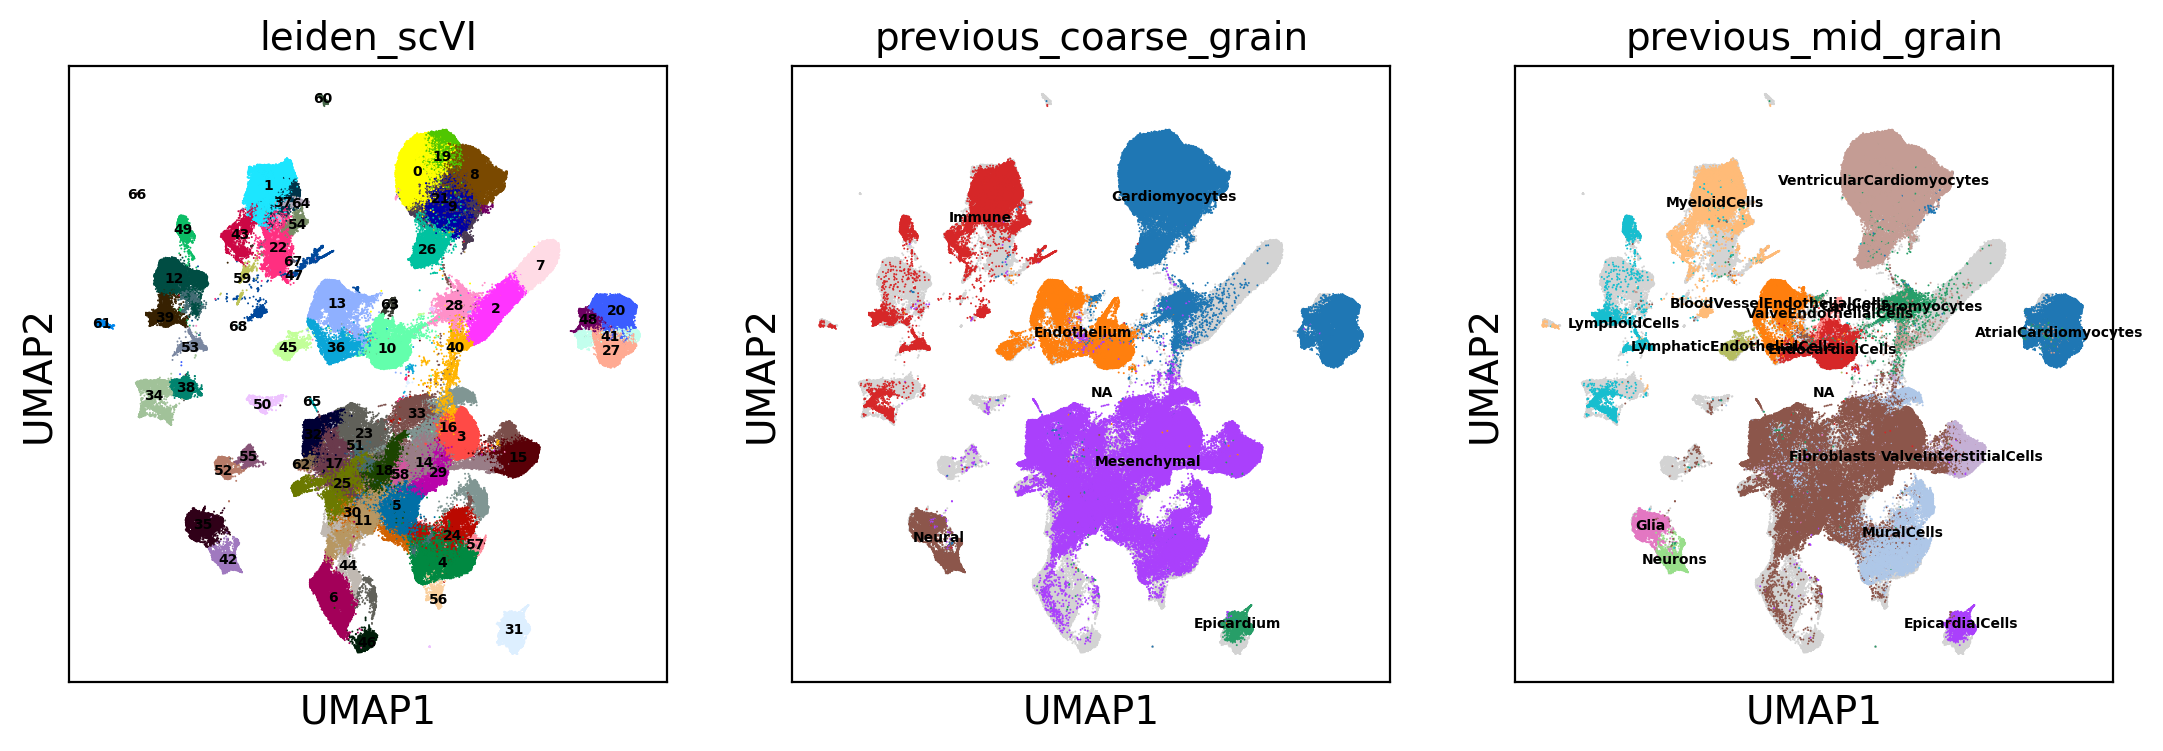

In [42]:
sc.settings.set_figure_params(dpi=200, facecolor='white', color_map = 'RdPu',)
sc.pl.umap(adata, color=['leiden_scVI','previous_coarse_grain','previous_mid_grain'], size=2, wspace=0.1, legend_loc='on data', legend_fontsize=5)

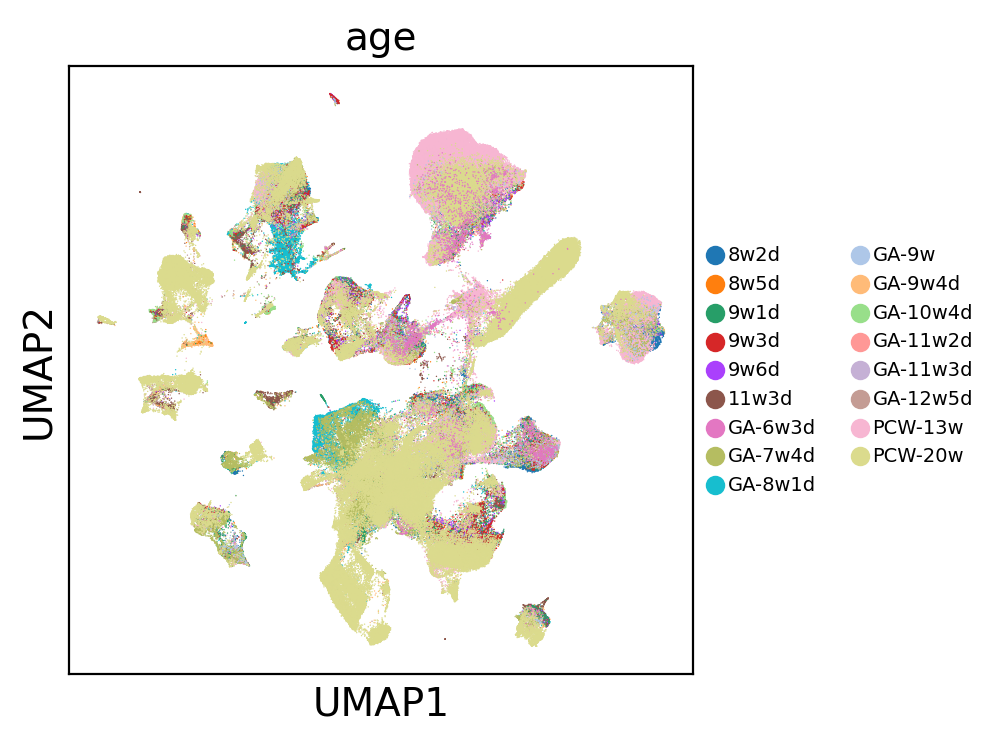

In [41]:
sc.pl.umap(adata, color=['age'], size=1, legend_fontsize=7)

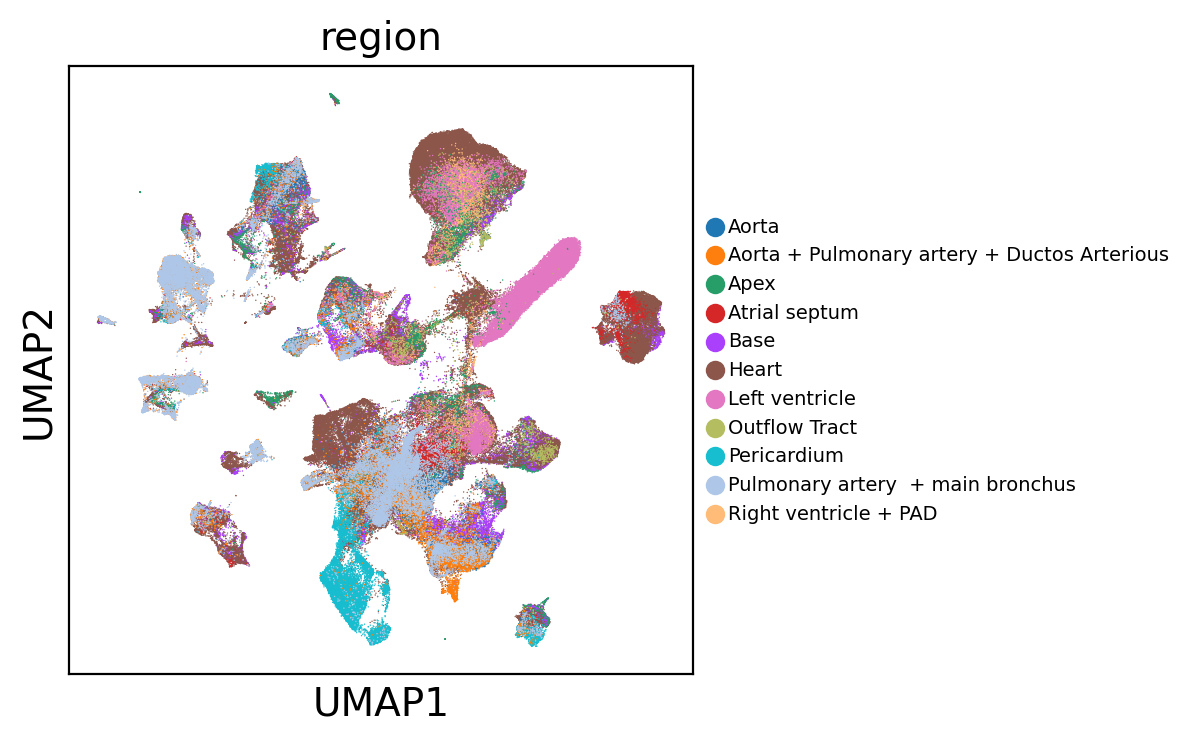

In [40]:
sc.pl.umap(adata, color=['region'], size=1, legend_fontsize=7)

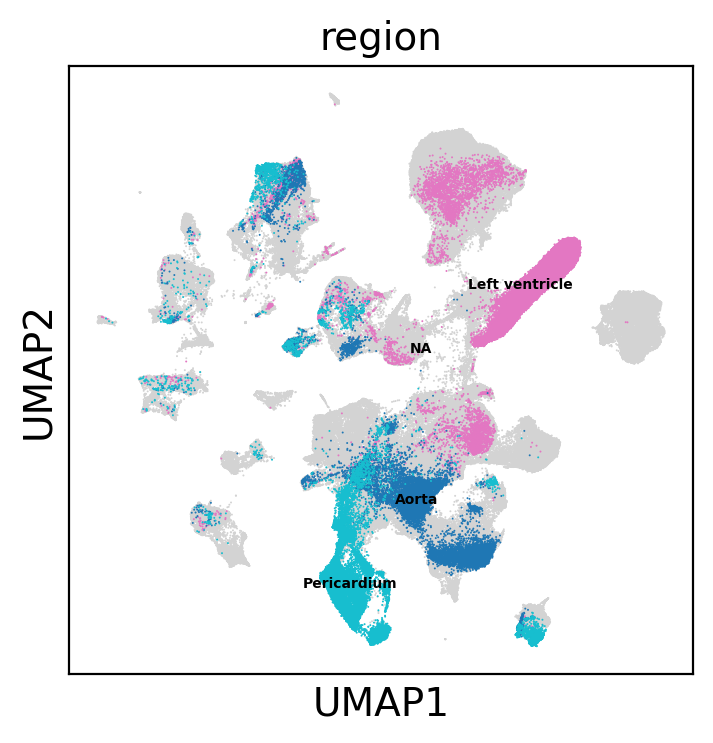

In [43]:
sc.pl.umap(adata, color=['region'], groups=['Pericardium','Aorta','Left ventricle'], size=2, legend_loc='on data', legend_fontsize=5)

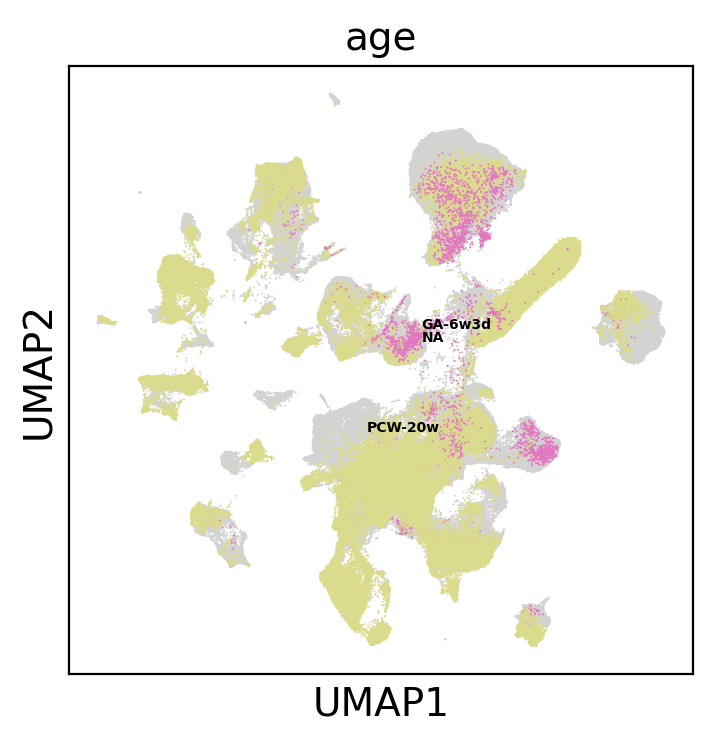

In [17]:
sc.pl.umap(adata, color=['age'], groups=['GA-6w3d','PCW-20w'], size=2, legend_loc='on data', legend_fontsize=5)

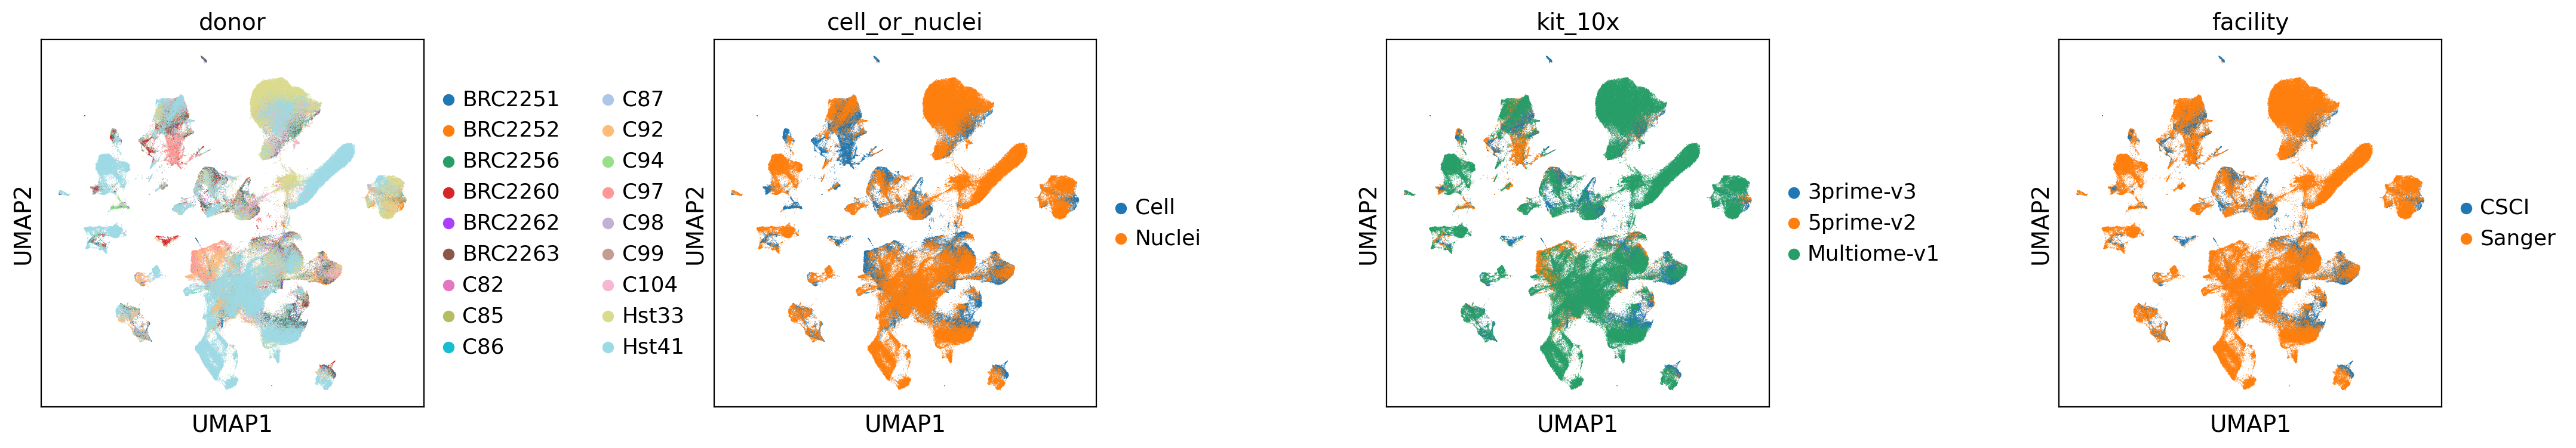

In [19]:
sc.pl.umap(adata, color=['donor','cell_or_nuclei','kit_10x','facility'], size=0.5, wspace=0.6)

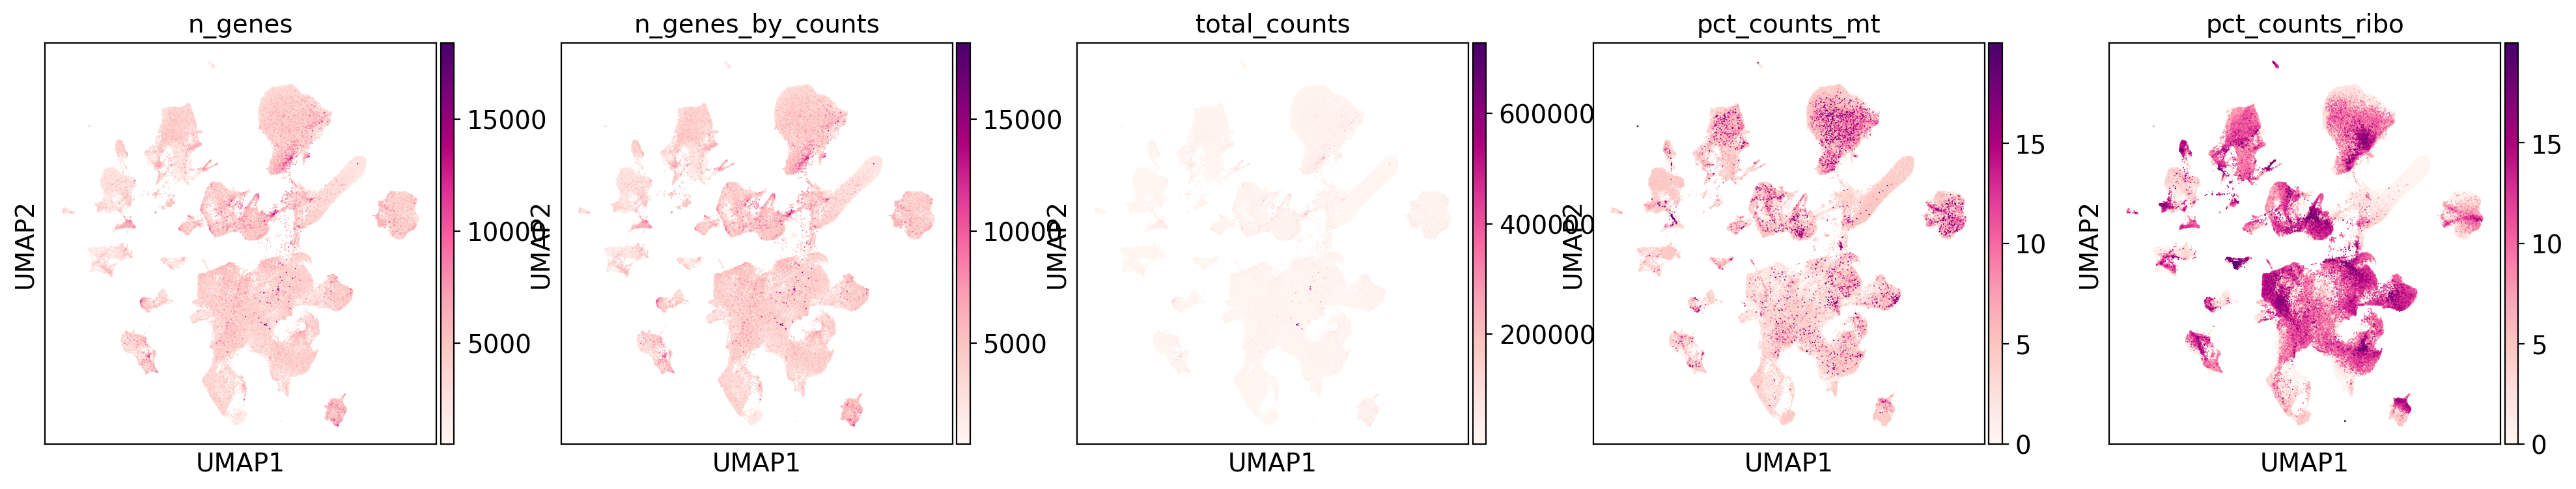

In [22]:
sc.settings.set_figure_params(dpi=200, color_map = 'RdPu',)
sc.pl.umap(adata, color=['n_genes', 'n_genes_by_counts',
       'total_counts','pct_counts_mt','pct_counts_ribo'], size=2, wspace=0.2, ncols=5)

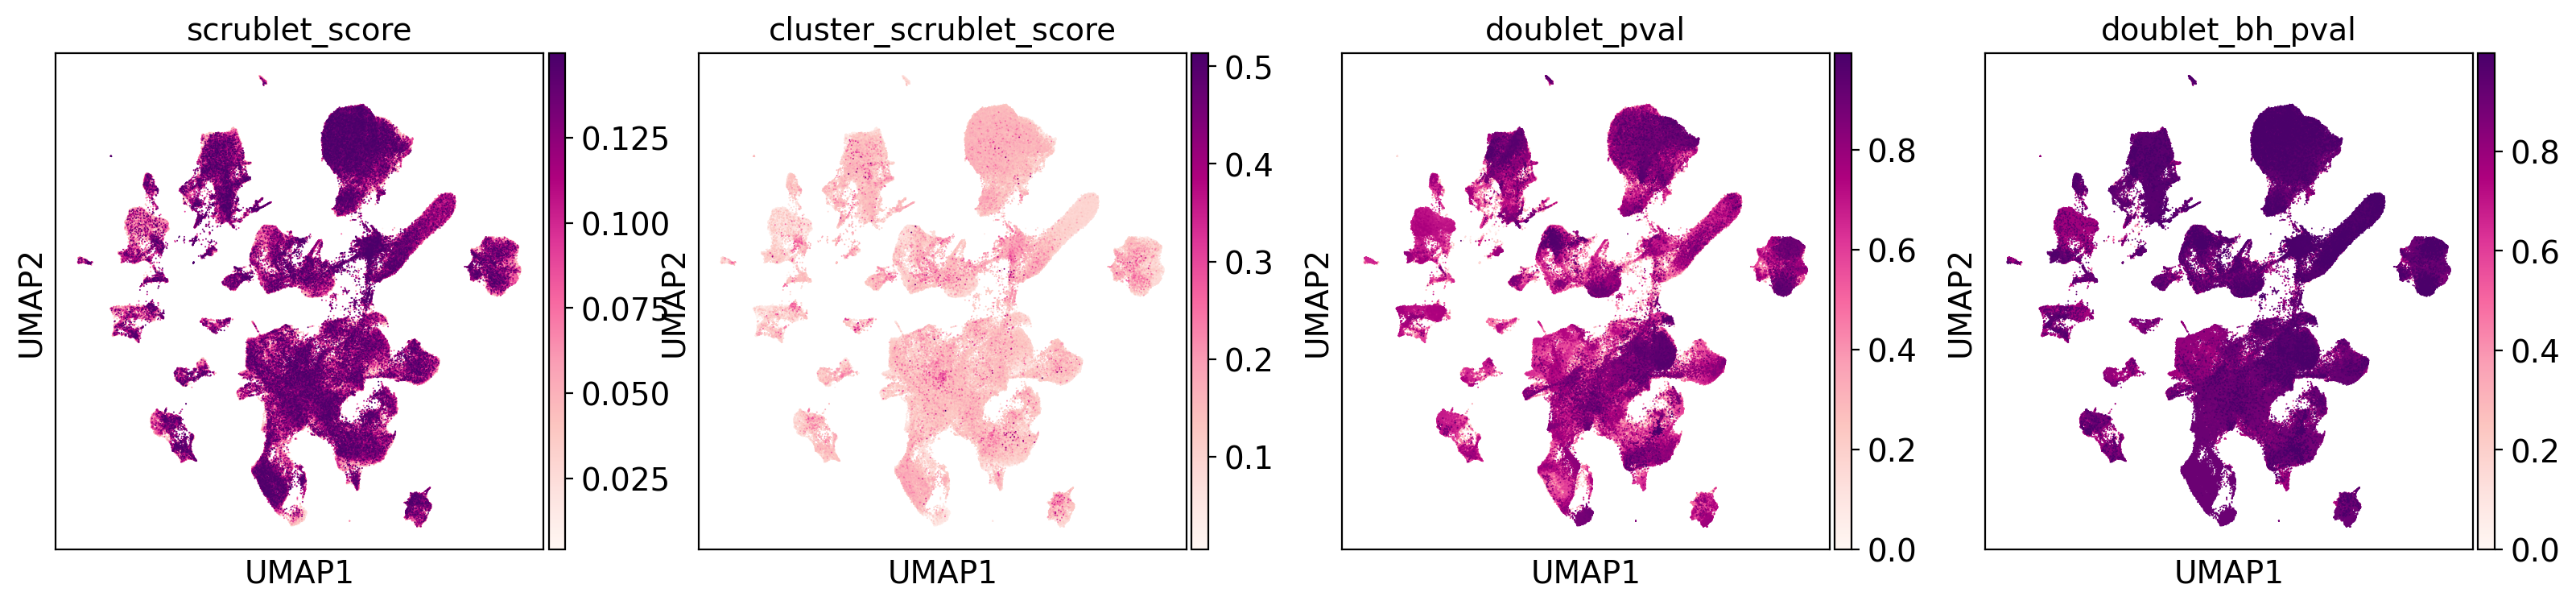

In [23]:
sc.pl.umap(adata, color=['scrublet_score','cluster_scrublet_score','doublet_pval','doublet_bh_pval'], size=2, wspace=0.2, ncols=5)

## Proportions

[]

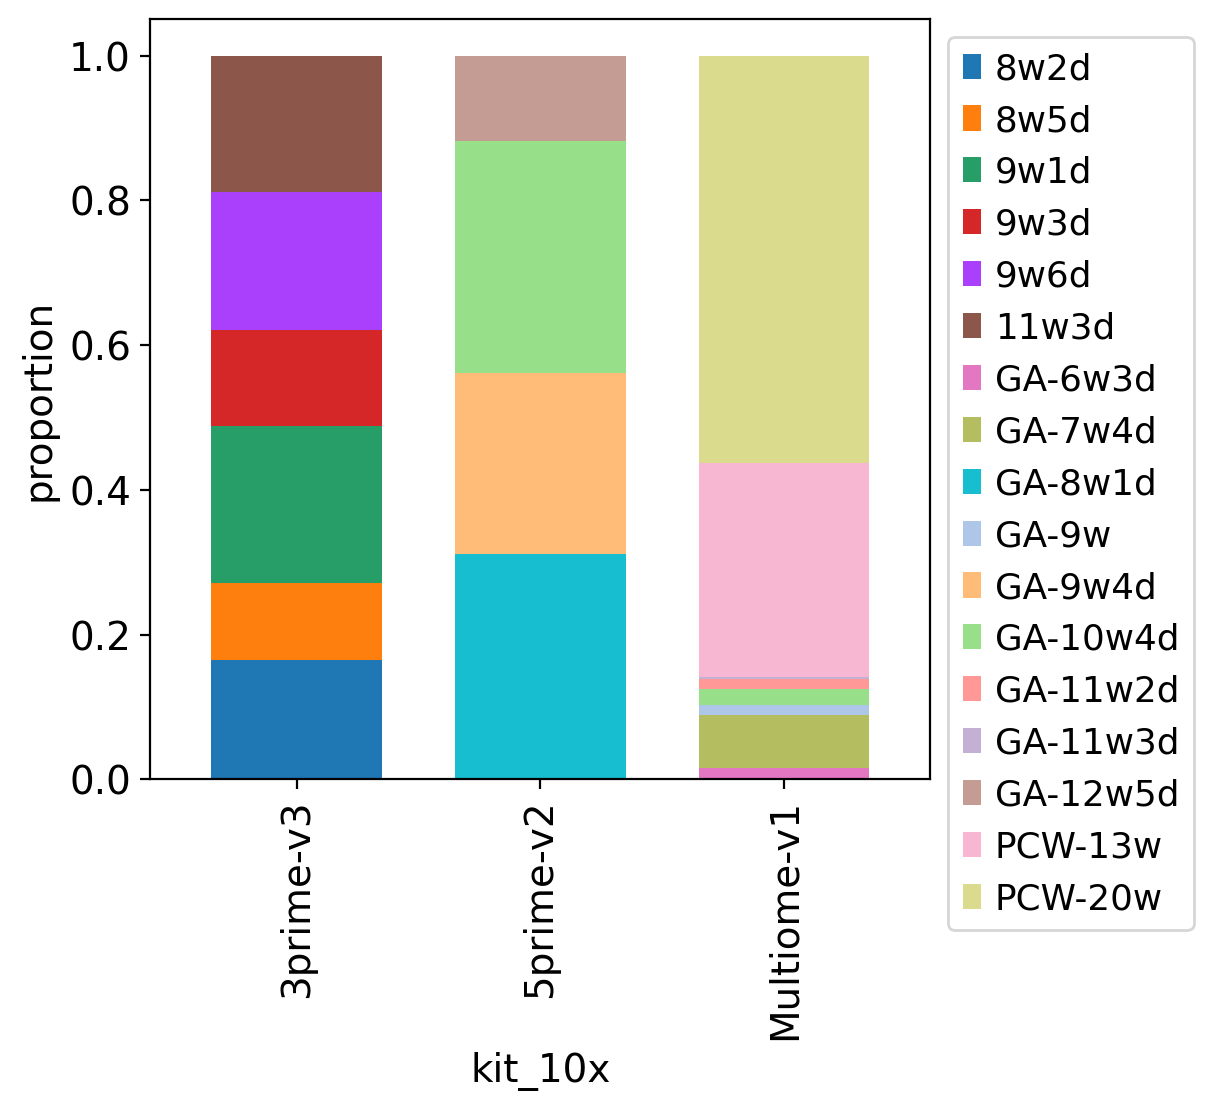

In [48]:
plt.rcParams['figure.figsize'] = 5,5
tmp = pd.crosstab(adata.obs['kit_10x'], adata.obs['age'], normalize='index')
# tmp.plot.bar().legend(loc=1)
ax = tmp.plot.bar(stacked=True,width=0.7)
ax.grid(False)
ax.set_ylabel('proportion')
ax.legend(bbox_to_anchor=(1.0, 1.0))
ax.plot()

## Reconstruct raw counts

In [49]:
adata_raw=sc.read_h5ad('/nfs/team205/heart/anndata_objects/Foetal/RNA_foetal_raw.h5ad')
print(adata_raw)

adata_raw=anndata.AnnData(X=adata_raw[adata.obs_names,:].X,
                      obs=adata.obs, # from annotated data
                      var=adata_raw.var,
                      obsm=adata.obsm, # from annotated data
                      obsp=adata.obsp # from annotated data
                               )
print(adata_raw)

AnnData object with n_obs × n_vars = 312100 × 36601
    obs: 'latent_RT_efficiency', 'latent_cell_probability', 'latent_scale', 'sangerID', 'combinedID', 'donor', 'donor_type', 'region', 'region_finest', 'age', 'gender', 'facility', 'cell_or_nuclei', 'modality', 'kit_10x', 'flushed', 'scrublet_score', 'scrublet_leiden', 'cluster_scrublet_score', 'doublet_pval', 'doublet_bh_pval', 'n_genes', 'n_counts', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'HB_score'
    var: 'gene_name_scRNA-0', 'gene_name_multiome-1'
    obsm: 'latent_gene_encoding'
AnnData object with n_obs × n_vars = 312100 × 36601
    obs: 'latent_RT_efficiency', 'latent_cell_probability', 'latent_scale', 'sangerID', 'combinedID', 'donor', 'donor_type', 'region', 'region_finest', 'age', 'gender', 'facility', 'cell_or_nuclei', 'modality', 'kit_10x', 'flushed'

In [50]:
### add CD45 sorting key ###
cd45 = pd.read_csv('/nfs/team205/heart/anndata_objects/Foetal/metadata/5prime_FACS.csv')
cd45.rename(columns={'FACS gate':'FACSgate'},inplace=True)
print(cd45)

adata_raw.obs = adata_raw.obs.reset_index().merge(cd45,how='left',on='sangerID').set_index('barcode')
adata_raw.obs[['FACSgate','sangerID']].value_counts()

            sangerID FACSgate
0  BHF_F_Hea10402917  CD45pos
1  BHF_F_Hea10402918  CD45neg
2  BHF_F_Hea11192323  CD45pos
3  BHF_F_Hea11192324  CD45neg
4  BHF_F_Hea11192325  CD45pos
5  BHF_F_Hea11192326  CD45neg
6  BHF_F_Hea11192327  CD45pos
7  BHF_F_Hea11192328  CD45neg


FACSgate  sangerID         
CD45neg   BHF_F_Hea11192328    12056
          BHF_F_Hea11192324    10553
          BHF_F_Hea11192326     9876
CD45pos   BHF_F_Hea11192325     7512
          BHF_F_Hea11192327     5865
CD45neg   BHF_F_Hea10402918     4340
CD45pos   BHF_F_Hea11192323     3418
          BHF_F_Hea10402917     2227
dtype: int64

In [51]:
adata_raw.obs['FACSgate'].unique()

array(['CD45pos', 'CD45neg', nan], dtype=object)

## Save

In [52]:
adata_raw.write('/nfs/team205/heart/anndata_objects/Foetal/RNA_foetal_post-scVI_raw.h5ad')

... storing 'sangerID' as categorical
... storing 'FACSgate' as categorical


In [ ]:
adata_raw=sc.read_h5ad('/nfs/team205/heart/anndata_objects/Foetal/RNA_foetal_post-scVI_raw.h5ad')
adata_raw